### Import Library

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

import re
from tqdm import tqdm

In [290]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, 'figure.figsize':(15,8)},
        style='darkgrid',
       )

### GPU checking

In [291]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6076393057699122386
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5767102464
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10807129000808855254
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


### Import data

In [292]:
data = pd.read_csv("data/data.csv")

In [293]:
data.head()

,OBJECTID_x,ID,pH,As,Cd,Ni,Pb,Zn,Hg,slope,...,HYDGRP_C,HYDGRP_D,ANION_EXCL,SOL_CRK,SOL_K1,CLAY1,SILT1,SAND1,ROCK1,SOL_EC1
0,1,KW-SK-S-36,7.63,17.46,0.480,1.65,91.10,NaN,0.0,36.896198,...,0,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0
1,2,KW-SK-S-37,5.25,1.25,0.050,0.34,58.77,NaN,0.0,28.025801,...,0,0,0.5,0.5,15.93,15.0,48.0,37.0,28.0,0
2,3,KW-SK-S-66,7.72,1.39,0.070,0.59,92.43,NaN,0.0,32.659199,...,0,0,0.5,0.5,43.15,6.0,45.0,50.0,58.0,0
3,4,KW-SK-CS-03,8.41,6.07,0.105,1.14,2.75,NaN,0.0,27.927500,...,0,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0
4,5,KW-YH-PS-01,8.30,32.70,3.700,1.10,4700.00,NaN,0.0,36.872700,...,0,0,0.5,0.5,25.77,10.0,30.0,60.0,11.0,0


### insight

#### HYDGRP Distribution

<AxesSubplot:title={'center':'HYDGROUP Distribution'}, xlabel='HYDGRP', ylabel='As'>

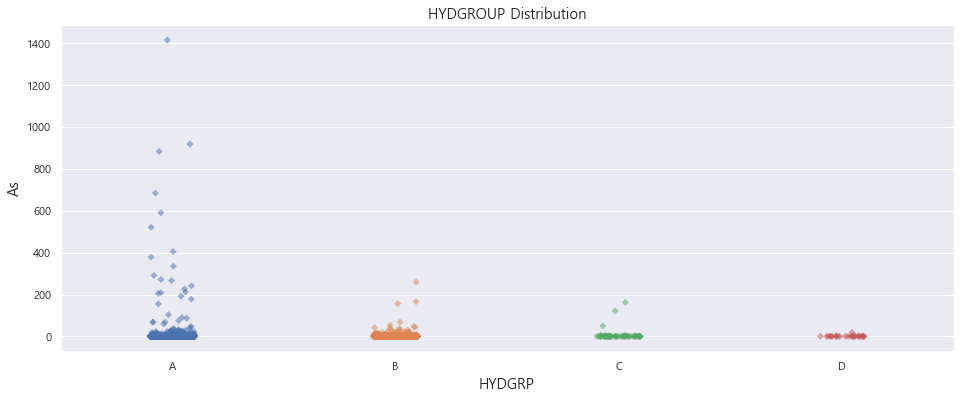

In [294]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set_title('HYDGROUP Distribution', size='large')
ax.set_xlabel('HYDGROUP', size='large')
ax.set_ylabel('As Concentration', size='large')

sns.stripplot(x = 'HYDGRP', y = 'As', data = data, order = ['A','B','C','D'], ax=ax, marker='D', alpha=.5)

<AxesSubplot:title={'center':'HYDGROUP Distribution'}, xlabel='HYDGRP', ylabel='Cd'>

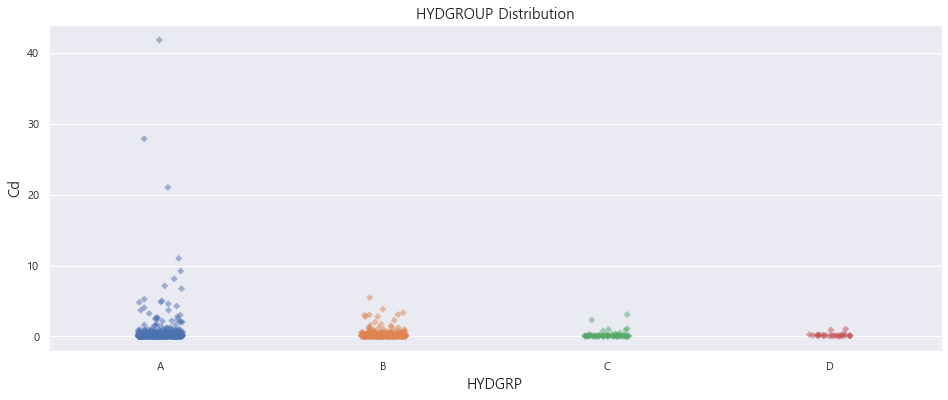

In [295]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set_title('HYDGROUP Distribution', size='large')
ax.set_xlabel('HYDGROUP', size='large')
ax.set_ylabel('Cd Concentration', size='large')

sns.stripplot(x = 'HYDGRP', y = 'Cd', data = data, order = ['A','B','C','D'], ax=ax, marker='D', alpha=.5)

<AxesSubplot:title={'center':'HYDGROUP Distribution'}, xlabel='HYDGRP', ylabel='Ni'>

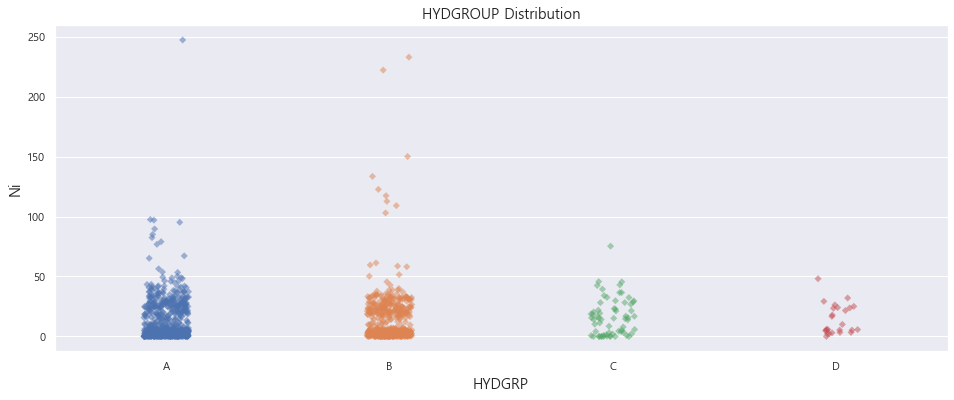

In [296]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.set_title('HYDGROUP Distribution', size='large')
ax.set_xlabel('HYDGROUP', size='large')
ax.set_ylabel('Ni Concentration', size='large')

sns.stripplot(x = 'HYDGRP', y = 'Ni', data = data, order = ['A','B','C','D'], ax=ax, marker='D', alpha=.5)

#### Curve Distribution

In [297]:
def visual_curve(data, value):
    fig, ax = plt.subplots(figsize=(16, 6))

    ax.set_title('Curve Distribution', size='large')
    ax.set_xlabel('profile curve', size='large')
    ax.set_ylabel(value+' Concentration', size='large')

    plt.scatter(x = 'profile_curve', y = value, data = data, marker='D', alpha=.5)
    plt.show()

    fig, ax = plt.subplots(figsize=(16, 6))

    ax.set_title('Curve Distribution', size='large')
    ax.set_xlabel('planform curve', size='large')
    ax.set_ylabel(value+' Concentration', size='large')

    plt.scatter(x = 'planform_curve', y = value, data = data, marker='D', alpha=.5, c='red')
    plt.show()

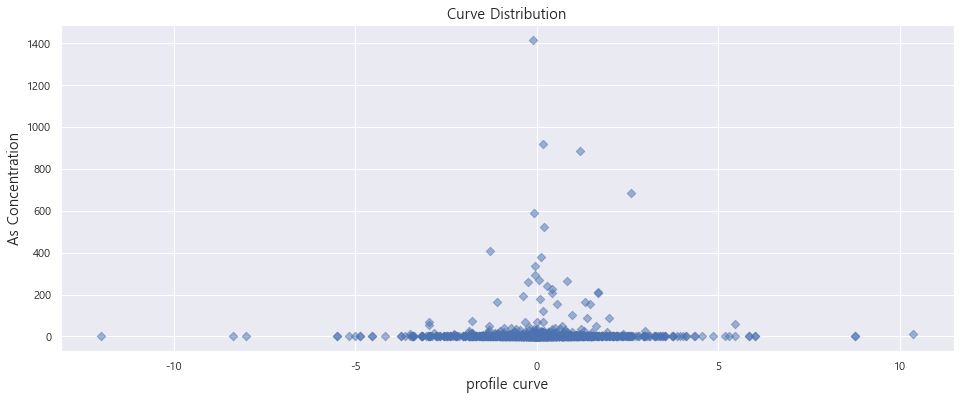

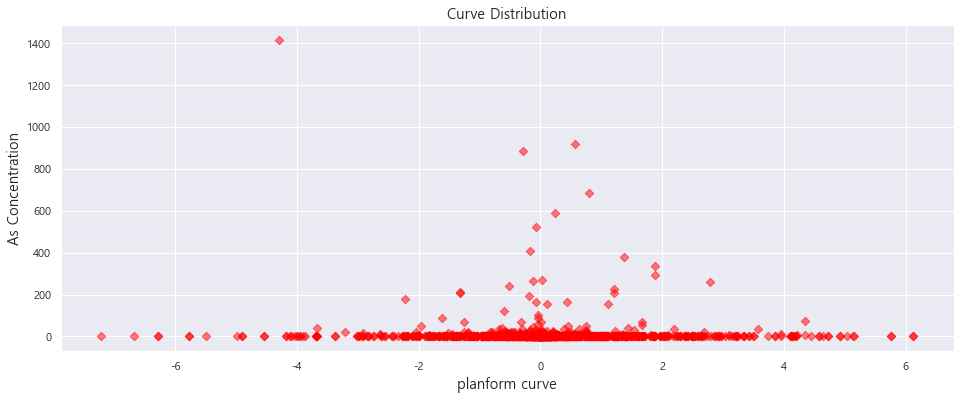

In [298]:
visual_curve(data, 'As')

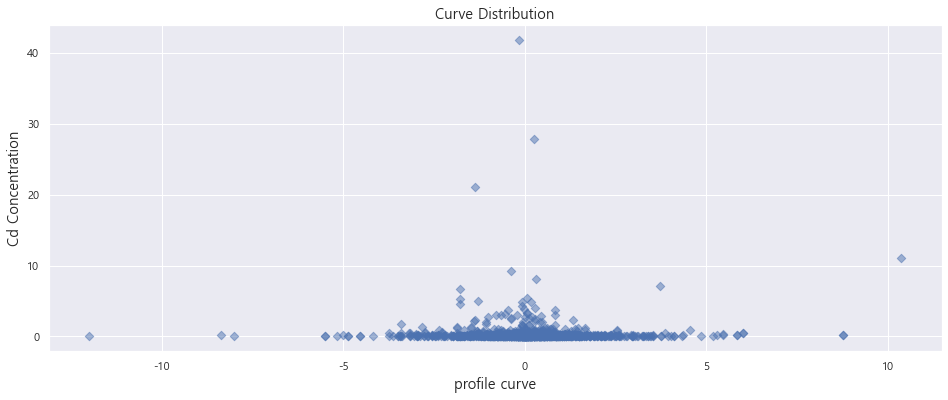

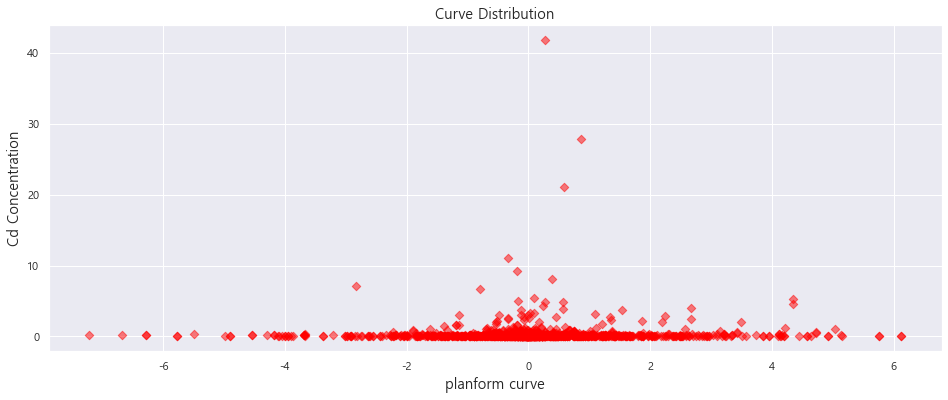

In [299]:
visual_curve(data, 'Cd')

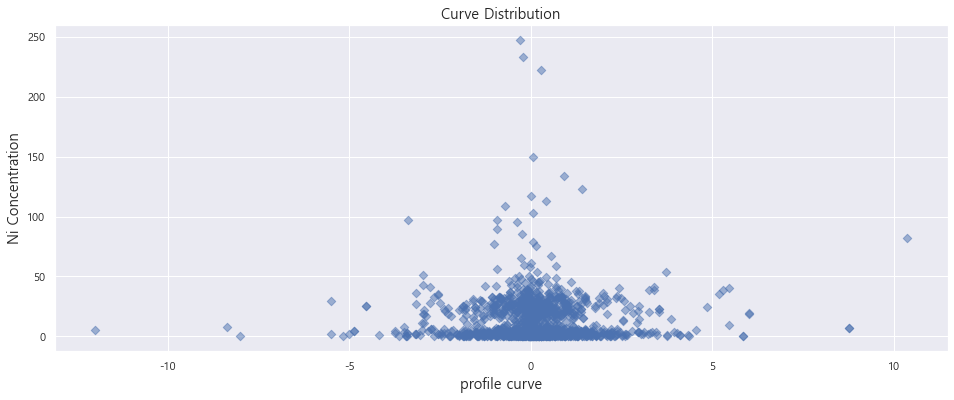

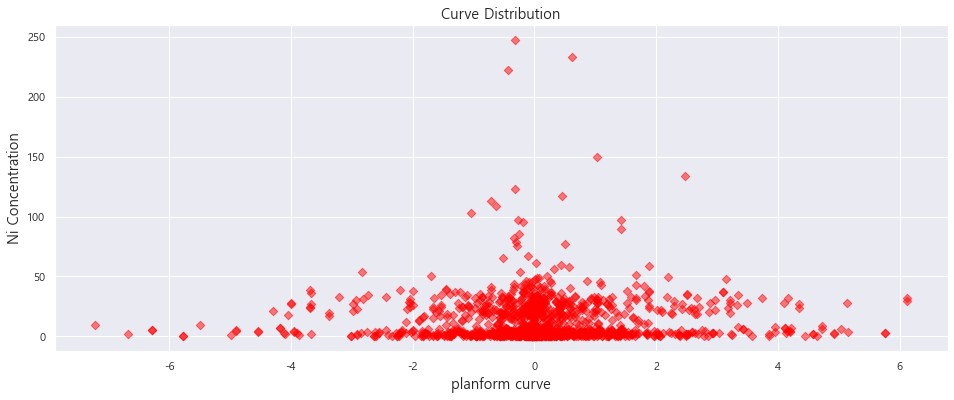

In [300]:
visual_curve(data, 'Ni')

### Processing missing data & Drop unnecessary data

In [301]:
data.info()

"""
    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)
    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)
    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)
    Ni = 1458/1458 = 100% -> good
    Pb = 757/1458 = 51.9% / 48.1% -> eliminate
    Zn = 337/1458 = 23.1% / 76.9% -> eliminate
    Hg = All 0 
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   OBJECTID_x      1458 non-null   int64  
 1   ID              1458 non-null   object 
 2   pH              1458 non-null   float64
 3   As              1458 non-null   float64
 4   Cd              1458 non-null   float64
 5   Ni              1458 non-null   float64
 6   Pb              757 non-null    float64
 7   Zn              337 non-null    object 
 8   Hg              1458 non-null   float64
 9   slope           1458 non-null   float64
 10  altitude        1458 non-null   float64
 11  profile_curve   1458 non-null   float64
 12  profile_c_num   1458 non-null   float64
 13  profile_c_abs   1458 non-null   int64  
 14  planform_curve  1458 non-null   float64
 15  planform_c_num  1458 non-null   float64
 16  planform_c_abs  1458 non-null   int64  
 17  HYDGRP          1458 non-null   o

'\n    pH = 1457/1458 = 99.9% / 0.1% -> hot deck(mean)\n    As = 1390/1458 = 95.3% / 4.7% -> hot deck(mean)\n    Cd = 1261/1458 = 86.5% / 13.5% -> hot deck(mean)\n    Ni = 1458/1458 = 100% -> good\n    Pb = 757/1458 = 51.9% / 48.1% -> eliminate\n    Zn = 337/1458 = 23.1% / 76.9% -> eliminate\n    Hg = All 0 \n'

<AxesSubplot:>

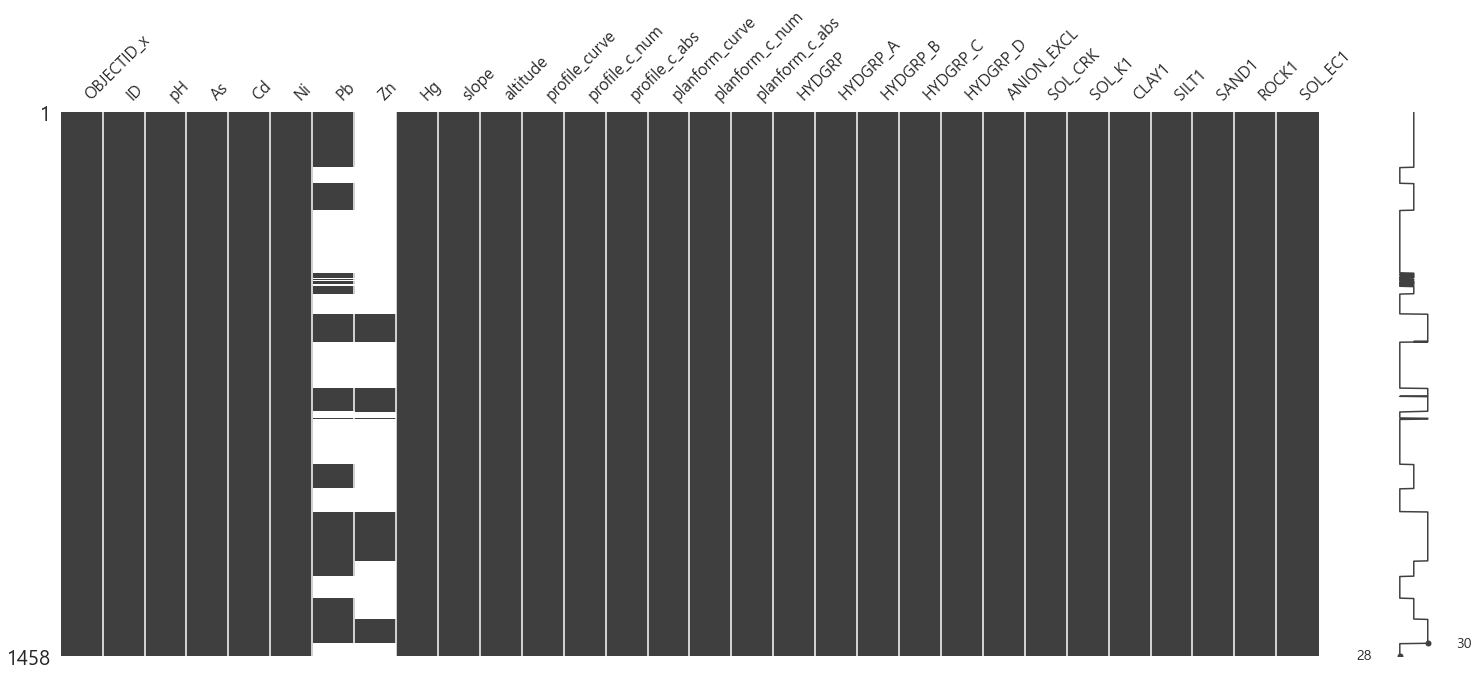

In [302]:
msno.matrix(data)

In [303]:
data = data.drop(['ID'], axis = 1)

# pd.get_dummies X, Negative data to 0, Postive data to 1
data = data.drop(['HYDGRP','profile_curve','planform_curve','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)

### train / test split & eliminate outlier

In [304]:
def eli_outlier(data, value):
        q1 = data[value].quantile(0.25)
        q3 = data[value].quantile(0.75)
        
        iqr = q3 - q1
        
        q1_condition = data[value] < q1-1.5*iqr
        q3_condition = data[value] > q3+1.5*iqr
        
        reset_q1_index = data[q1_condition].index
        reset_q3_index = data[q3_condition].index
        
        data.drop(reset_q1_index, inplace = True)
        data.drop(reset_q3_index, inplace = True)        

In [305]:
train, test = train_test_split(data, test_size=0.2, random_state=605)

In [306]:
# pd.get_dummies X, Negative data to 0, Postive data to 1
# train

As_train = train.drop(['OBJECTID_x','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_train = train.drop(['OBJECTID_x','As','Ni','Pb','Zn','Hg'], axis=1)
Ni_train = train.drop(['OBJECTID_x','As','Cd','Pb','Zn','Hg'], axis=1)
Pb_train = train.drop(['OBJECTID_x','As','Cd','Ni','Zn','Hg'], axis=1)
Zn_train = train.drop(['OBJECTID_x','As','Cd','Ni','Pb','Hg'], axis=1)

eli_outlier(As_train, 'As')
eli_outlier(Cd_train, 'Cd')
eli_outlier(Ni_train, 'Ni')

In [307]:
# test

As_test = test
Cd_test = test
Ni_test = test

eli_outlier(As_test, 'As')
eli_outlier(Cd_test, 'Cd')
eli_outlier(Ni_test, 'Ni')

As_test = As_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Cd_test = Cd_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)
Ni_test = Ni_test.drop(['OBJECTID_x','As','Cd','Ni','Pb','Zn','Hg'], axis=1)

In [308]:
As_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031 entries, 670 to 1162
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              1031 non-null   float64
 1   As              1031 non-null   float64
 2   slope           1031 non-null   float64
 3   altitude        1031 non-null   float64
 4   profile_c_num   1031 non-null   float64
 5   profile_c_abs   1031 non-null   int64  
 6   planform_c_num  1031 non-null   float64
 7   planform_c_abs  1031 non-null   int64  
 8   HYDGRP_A        1031 non-null   int64  
 9   HYDGRP_B        1031 non-null   int64  
 10  HYDGRP_C        1031 non-null   int64  
 11  HYDGRP_D        1031 non-null   int64  
 12  SOL_K1          1031 non-null   float64
 13  CLAY1           1031 non-null   float64
 14  SILT1           1031 non-null   float64
 15  SAND1           1031 non-null   float64
 16  ROCK1           1031 non-null   float64
dtypes: float64(11), int64(6)
memory

In [309]:
As_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225 entries, 960 to 353
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pH              225 non-null    float64
 1   slope           225 non-null    float64
 2   altitude        225 non-null    float64
 3   profile_c_num   225 non-null    float64
 4   profile_c_abs   225 non-null    int64  
 5   planform_c_num  225 non-null    float64
 6   planform_c_abs  225 non-null    int64  
 7   HYDGRP_A        225 non-null    int64  
 8   HYDGRP_B        225 non-null    int64  
 9   HYDGRP_C        225 non-null    int64  
 10  HYDGRP_D        225 non-null    int64  
 11  SOL_K1          225 non-null    float64
 12  CLAY1           225 non-null    float64
 13  SILT1           225 non-null    float64
 14  SAND1           225 non-null    float64
 15  ROCK1           225 non-null    float64
dtypes: float64(10), int64(6)
memory usage: 29.9 KB


### Check the value skewed

#### As

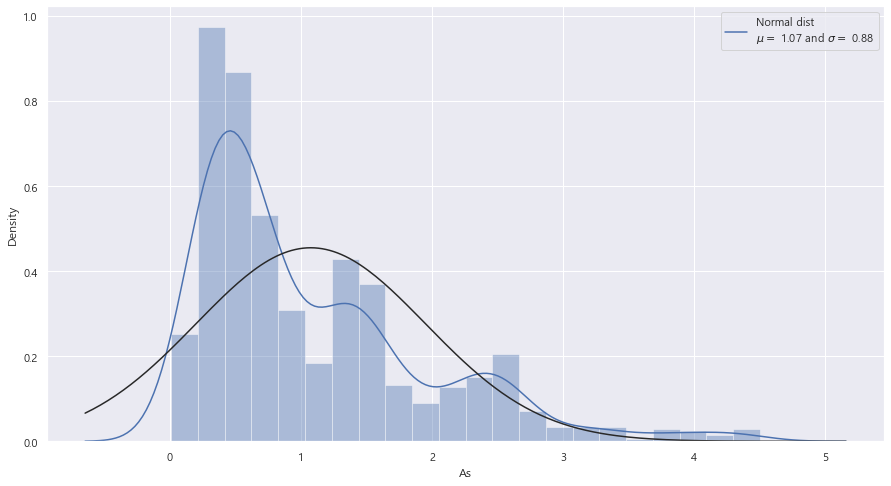

In [310]:
sns.distplot(As_train.As, fit = norm)
(mu, sigma) = norm.fit(As_train['As'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

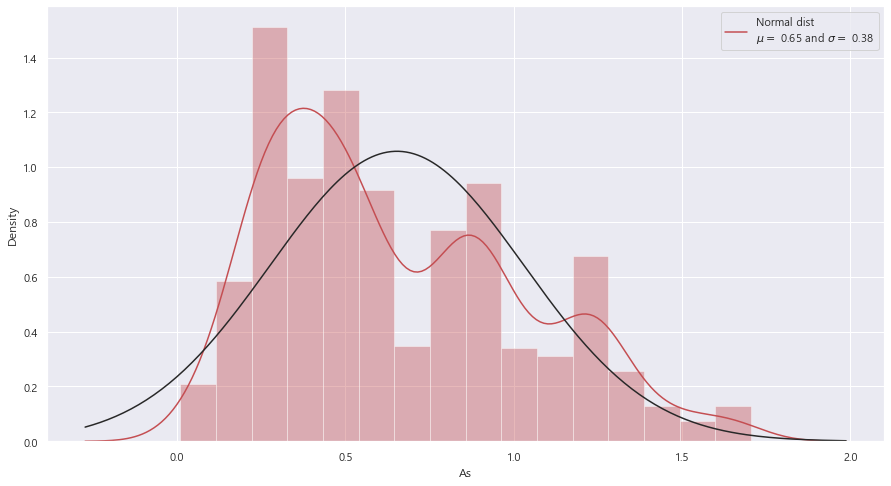

In [311]:
# 로그변환

sns.distplot(np.log1p(As_train.As), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(As_train['As']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Cd

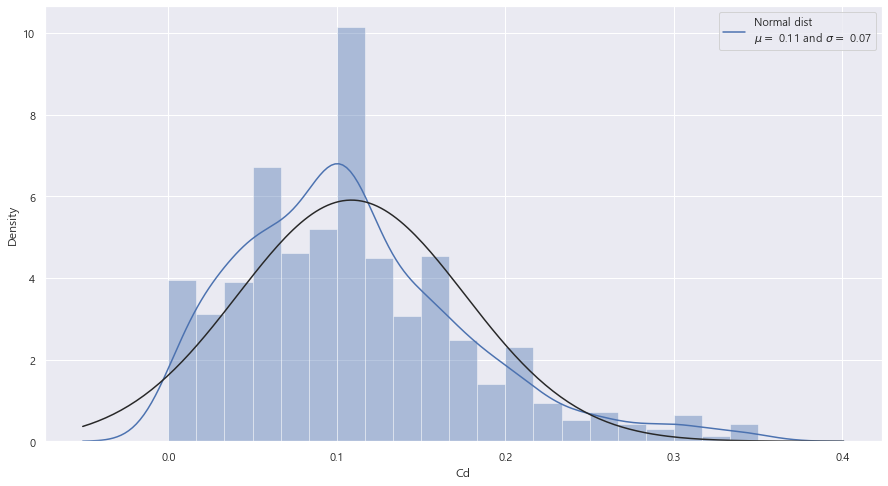

In [312]:
sns.distplot(Cd_train.Cd, fit = norm)
(mu, sigma) = norm.fit(Cd_train['Cd'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

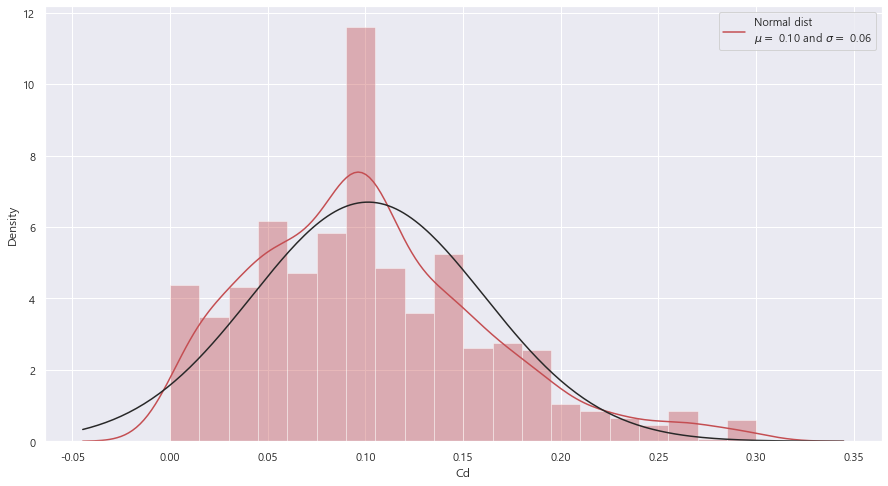

In [313]:
# 로그변환

sns.distplot(np.log1p(Cd_train.Cd), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Cd_train['Cd']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Ni

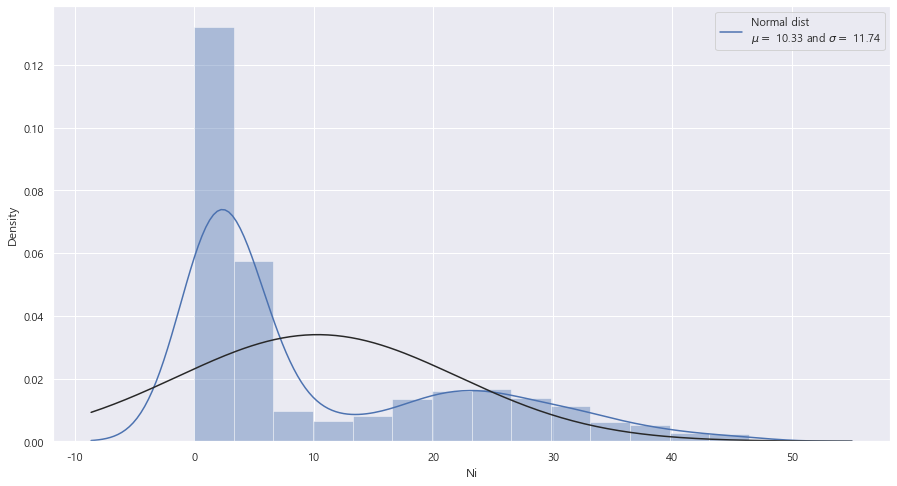

In [314]:
sns.distplot(Ni_train.Ni, fit = norm)
(mu, sigma) = norm.fit(Ni_train['Ni'])
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

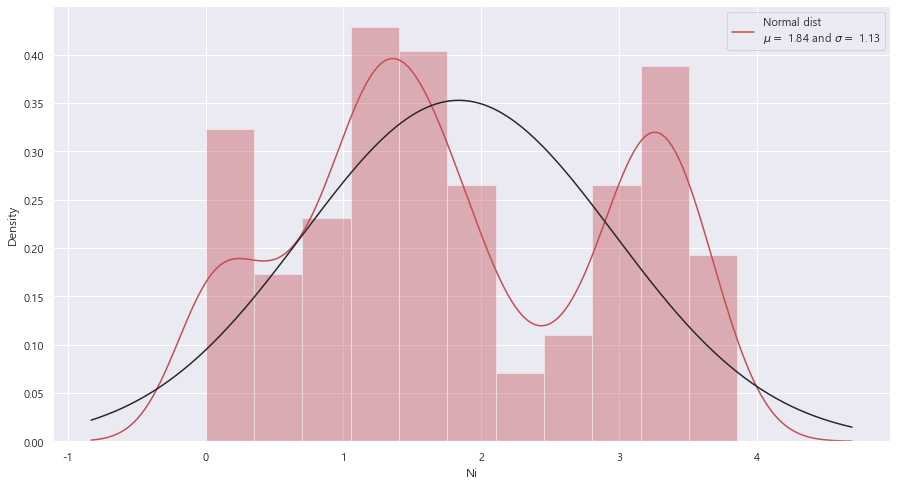

In [315]:
# 로그변환

sns.distplot(np.log1p(Ni_train.Ni), fit = norm, color = 'r')
(mu, sigma) = norm.fit(np.log1p(Ni_train['Ni']))
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],loc = 'best')
plt.show()

#### Log-Transformation

In [316]:
As_train.As = np.log1p(As_train.As)
Cd_train.Cd = np.log1p(Cd_train.Cd)
Ni_train.Ni = np.log1p(Ni_train.Ni)

"""
As_train.altitude = np.log1p(As_train.altitude)
Cd_train.altitude = np.log1p(Cd_train.altitude)
Ni_train.altitude = np.log1p(Ni_train.altitude)

As_train.slope = np.log1p(As_train.slope)
Cd_train.slope = np.log1p(Cd_train.slope)
Ni_train.slope = np.log1p(Ni_train.slope)
"""

'\nAs_train.altitude = np.log1p(As_train.altitude)\nCd_train.altitude = np.log1p(Cd_train.altitude)\nNi_train.altitude = np.log1p(Ni_train.altitude)\n\nAs_train.slope = np.log1p(As_train.slope)\nCd_train.slope = np.log1p(Cd_train.slope)\nNi_train.slope = np.log1p(Ni_train.slope)\n'

#### Scaling

In [317]:
As_X = As_train.drop('As', axis=1)
As_y = As_train.As

Cd_X = Cd_train.drop('Cd', axis=1)
Cd_y = Cd_train.Cd

Ni_X = Ni_train.drop('Ni', axis=1)
Ni_y = Ni_train.Ni

In [318]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
#scaler = RobustScaler()

As_X = pd.DataFrame(scaler.fit_transform(As_X), columns=As_X.columns)
Cd_X = pd.DataFrame(scaler.fit_transform(Cd_X), columns=Cd_X.columns)
Ni_X = pd.DataFrame(scaler.fit_transform(Ni_X), columns=Ni_X.columns)

#### 10-Fold Crossvalidation

In [319]:
kf = KFold(n_splits = 20, random_state = 605, shuffle = True)

#### 1) NGBRegressor

In [320]:
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

def ngb_model(test, X, y):
    ngb = NGBRegressor(random_state = 605, n_estimators=1000, learning_rate = 0.001)
    
    ngb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []
    
    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        ngb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in ngb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in ngb.predict(test)]) / 20
        ngb_pred += sub_pred

    print(f'{ngb.__class__.__name__}의 20fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{ngb.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return ngb_pred

In [321]:
As_ngb_pred = ngb_model(As_test, As_X, As_y)

[iter 0] loss=0.4473 val_loss=0.0000 scale=1.0000 norm=0.5687
[iter 100] loss=0.4307 val_loss=0.0000 scale=1.0000 norm=0.5559
[iter 200] loss=0.4164 val_loss=0.0000 scale=1.0000 norm=0.5455
[iter 300] loss=0.4032 val_loss=0.0000 scale=1.0000 norm=0.5370
[iter 400] loss=0.3919 val_loss=0.0000 scale=1.0000 norm=0.5304
[iter 500] loss=0.3777 val_loss=0.0000 scale=1.0000 norm=0.5235
[iter 600] loss=0.3642 val_loss=0.0000 scale=2.0000 norm=1.0360
[iter 700] loss=0.3508 val_loss=0.0000 scale=1.0000 norm=0.5133
[iter 800] loss=0.3388 val_loss=0.0000 scale=2.0000 norm=1.0200
[iter 900] loss=0.3279 val_loss=0.0000 scale=2.0000 norm=1.0145
[iter 0] loss=0.3191 val_loss=0.0000 scale=2.0000 norm=1.0127
[iter 100] loss=0.3115 val_loss=0.0000 scale=1.0000 norm=0.5057
[iter 200] loss=0.3045 val_loss=0.0000 scale=1.0000 norm=0.5049
[iter 300] loss=0.2984 val_loss=0.0000 scale=2.0000 norm=1.0083
[iter 400] loss=0.2927 val_loss=0.0000 scale=1.0000 norm=0.5035
[iter 500] loss=0.2868 val_loss=0.0000 scale

In [322]:
Cd_ngb_pred = ngb_model(Cd_test, Cd_X, Cd_y)

[iter 0] loss=-1.4001 val_loss=0.0000 scale=1.0000 norm=0.4989
[iter 100] loss=-1.4150 val_loss=0.0000 scale=1.0000 norm=0.4854
[iter 200] loss=-1.4304 val_loss=0.0000 scale=2.0000 norm=0.9480
[iter 300] loss=-1.4458 val_loss=0.0000 scale=1.0000 norm=0.4636
[iter 400] loss=-1.4574 val_loss=0.0000 scale=2.0000 norm=0.9133
[iter 500] loss=-1.4712 val_loss=0.0000 scale=1.0000 norm=0.4504
[iter 600] loss=-1.4838 val_loss=0.0000 scale=2.0000 norm=0.8916
[iter 700] loss=-1.4947 val_loss=0.0000 scale=2.0000 norm=0.8849
[iter 800] loss=-1.5048 val_loss=0.0000 scale=1.0000 norm=0.4396
[iter 900] loss=-1.5138 val_loss=0.0000 scale=1.0000 norm=0.4373
[iter 0] loss=-1.5231 val_loss=0.0000 scale=1.0000 norm=0.4354
[iter 100] loss=-1.5321 val_loss=0.0000 scale=1.0000 norm=0.4326
[iter 200] loss=-1.5399 val_loss=0.0000 scale=1.0000 norm=0.4309
[iter 300] loss=-1.5471 val_loss=0.0000 scale=2.0000 norm=0.8590
[iter 400] loss=-1.5543 val_loss=0.0000 scale=1.0000 norm=0.4280
[iter 500] loss=-1.5612 val_l

In [323]:
Ni_ngb_pred = ngb_model(Ni_test, Ni_X, Ni_y)

[iter 0] loss=1.5409 val_loss=0.0000 scale=1.0000 norm=1.1022
[iter 100] loss=1.5152 val_loss=0.0000 scale=1.0000 norm=1.0773
[iter 200] loss=1.4936 val_loss=0.0000 scale=1.0000 norm=1.0564
[iter 300] loss=1.4730 val_loss=0.0000 scale=1.0000 norm=1.0376
[iter 400] loss=1.4523 val_loss=0.0000 scale=2.0000 norm=2.0386
[iter 500] loss=1.4319 val_loss=0.0000 scale=1.0000 norm=1.0022
[iter 600] loss=1.4133 val_loss=0.0000 scale=2.0000 norm=1.9746
[iter 700] loss=1.3927 val_loss=0.0000 scale=2.0000 norm=1.9427
[iter 800] loss=1.3730 val_loss=0.0000 scale=2.0000 norm=1.9149
[iter 900] loss=1.3553 val_loss=0.0000 scale=2.0000 norm=1.8914
[iter 0] loss=1.3477 val_loss=0.0000 scale=2.0000 norm=1.8848
[iter 100] loss=1.3320 val_loss=0.0000 scale=1.0000 norm=0.9323
[iter 200] loss=1.3182 val_loss=0.0000 scale=2.0000 norm=1.8493
[iter 300] loss=1.3044 val_loss=0.0000 scale=2.0000 norm=1.8347
[iter 400] loss=1.2908 val_loss=0.0000 scale=2.0000 norm=1.8210
[iter 500] loss=1.2783 val_loss=0.0000 scale

#### 2) RandomForestRegressor

In [324]:
def rf_model(test, X, y):
    rf = RandomForestRegressor(random_state = 605, n_estimators = 1000)
    
    rf_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        rf.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(test)]) / 20
        rf_pred += sub_pred

    print(f'{rf.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{rf.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return rf_pred

In [325]:
As_rf_pred = rf_model(As_test, As_X, As_y)

RandomForestRegressor의 10fold 평균 RMSE는 0.8434525116519911, RandomForestRegressor의 10fold 평균 R2 score는 -1.0157975532851178


In [326]:
Cd_rf_pred = rf_model(Cd_test, Cd_X, Cd_y)

RandomForestRegressor의 10fold 평균 RMSE는 0.06573278952653076, RandomForestRegressor의 10fold 평균 R2 score는 -0.016847349330103477


In [327]:
Ni_rf_pred = rf_model(Ni_test, Ni_X, Ni_y)

RandomForestRegressor의 10fold 평균 RMSE는 8.828357163741334, RandomForestRegressor의 10fold 평균 R2 score는 -53.38845211396698


#### 3) ExtraTreesRegressor

In [328]:
def etc_model(test, X, y):
    etc = ExtraTreesRegressor(random_state = 605, n_estimators = 1000)
    
    etc_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        etc.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in etc.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in etc.predict(test)]) / 20
        etc_pred += sub_pred

    print(f'{etc.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{etc.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return etc_pred

In [329]:
As_etc_pred = etc_model(As_test, As_X, As_y)

ExtraTreesRegressor의 10fold 평균 RMSE는 0.868413883469974, ExtraTreesRegressor의 10fold 평균 R2 score는 -1.7126147995933672


In [330]:
Cd_etc_pred = etc_model(Cd_test, Cd_X, Cd_y)

ExtraTreesRegressor의 10fold 평균 RMSE는 0.0679668732818541, ExtraTreesRegressor의 10fold 평균 R2 score는 -0.13796893724062115


In [331]:
Ni_etc_pred = etc_model(Ni_test, Ni_X, Ni_y)

ExtraTreesRegressor의 10fold 평균 RMSE는 8.07515598178952, ExtraTreesRegressor의 10fold 평균 R2 score는 -76.74706912321582


#### 4) GradientBoostingRegressor

In [332]:
def gb_model(test, X, y):
    gb = GradientBoostingRegressor(random_state = 605, n_estimators = 1000, learning_rate = 0.001, max_depth = 5)
    
    gb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        gb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in gb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in gb.predict(test)]) / 20
        gb_pred += sub_pred

    print(f'{gb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{gb.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return gb_pred

In [333]:
As_gb_pred = gb_model(As_test, As_X, As_y)

GradientBoostingRegressor의 10fold 평균 RMSE는 0.8619420281536048, GradientBoostingRegressor의 10fold 평균 R2 score는 -0.5957037481422504


In [334]:
Cd_gb_pred = gb_model(Cd_test, Cd_X, Cd_y)

GradientBoostingRegressor의 10fold 평균 RMSE는 0.06606561957671193, GradientBoostingRegressor의 10fold 평균 R2 score는 -0.00018684068356498719


In [335]:
Ni_gb_pred = gb_model(Ni_test, Ni_X, Ni_y)

GradientBoostingRegressor의 10fold 평균 RMSE는 10.99720925098059, GradientBoostingRegressor의 10fold 평균 R2 score는 -17.640361053117395


#### 5) CatBoostRegressor

In [336]:
def cb_model(test, X, y):
    cb = CatBoostRegressor(random_state = 605, silent = True, depth = 5, learning_rate = 0.001)
    
    cb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        cb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in cb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in cb.predict(test)]) / 20
        cb_pred += sub_pred

    print(f'{cb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{cb.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return cb_pred

In [337]:
As_cb_pred = cb_model(As_test, As_X, As_y)

CatBoostRegressor의 10fold 평균 RMSE는 0.859374660671705, CatBoostRegressor의 10fold 평균 R2 score는 -0.47839391359402744


In [338]:
Cd_cb_pred = cb_model(Cd_test, Cd_X, Cd_y)

CatBoostRegressor의 10fold 평균 RMSE는 0.06646855418016227, CatBoostRegressor의 10fold 평균 R2 score는 -0.01053257879045017


In [339]:
Ni_cb_pred = cb_model(Ni_test, Ni_X, Ni_y)

CatBoostRegressor의 10fold 평균 RMSE는 11.748096942401215, CatBoostRegressor의 10fold 평균 R2 score는 -11.860161158588184


#### 6) LGBMRegressor

In [370]:
def lgbm_model(test, X, y):
    lgbm = LGBMRegressor(random_state = 605, max_depth = 4, n_estimators = 1000, num_leaves = 16, learning_rate = 0.001, num_iterations = 1000)
    
    lgbm_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        lgbm.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(test)]) / 20
        lgbm_pred += sub_pred

    print(f'{lgbm.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{lgbm.__class__.__name__}의 20fold 평균 R2 score는 {np.mean(r2_list)}')
    return lgbm_pred

In [371]:
As_lgbm_pred = lgbm_model(As_test, As_X, As_y)

LGBMRegressor의 10fold 평균 RMSE는 0.8563923561776996, LGBMRegressor의 20fold 평균 R2 score는 -0.5293827593610108


In [372]:
Cd_lgbm_pred = lgbm_model(Cd_test, Cd_X, Cd_y)

LGBMRegressor의 10fold 평균 RMSE는 0.0661764658700159, LGBMRegressor의 20fold 평균 R2 score는 -0.0038554862241381325


In [373]:
Ni_lgbm_pred = lgbm_model(Ni_test, Ni_X, Ni_y)

LGBMRegressor의 10fold 평균 RMSE는 11.377704032356359, LGBMRegressor의 20fold 평균 R2 score는 -15.409868628378636


#### 7) XGBRegressor

In [344]:
def xgb_model(test, X, y):
    xgb = XGBRegressor(random_state = 605, max_depth = 30, learning_rate = 0.1)
    
    xgb_pred = np.zeros((test.shape[0]))
    rmse_list = []
    r2_list = []

    for tr_idx, val_idx in kf.split(X, y) :
        tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
        val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
        xgb.fit(tr_x, tr_y)
        pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])

        rmse = np.sqrt(mean_squared_error(np.expm1(val_y), pred))
        r2 = r2_score(val_y, pred)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
        sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(test)]) / 20
        xgb_pred += sub_pred

    print(f'{xgb.__class__.__name__}의 10fold 평균 RMSE는 {np.mean(rmse_list)}, '+f'{xgb.__class__.__name__}의 10fold 평균 R2 score는 {np.mean(r2_list)}')
    return xgb_pred

In [345]:
As_xgb_pred = xgb_model(As_test, As_X, As_y)

XGBRegressor의 10fold 평균 RMSE는 0.9145540730655503, XGBRegressor의 10fold 평균 R2 score는 -2.0857954079804424


In [346]:
Cd_xgb_pred = xgb_model(Cd_test, Cd_X, Cd_y)

XGBRegressor의 10fold 평균 RMSE는 0.0693796360277191, XGBRegressor의 10fold 평균 R2 score는 -0.19148543575320726


In [347]:
Ni_xgb_pred = xgb_model(Ni_test, Ni_X, Ni_y)

XGBRegressor의 10fold 평균 RMSE는 8.589806398547797, XGBRegressor의 10fold 평균 R2 score는 -86.01521555703866


###  Blending Models

In [348]:
#As
ngb_As_test = pd.DataFrame()
rf_As_test = pd.DataFrame()
etc_As_test = pd.DataFrame()
gb_As_test = pd.DataFrame()
cb_As_test = pd.DataFrame()
lgbm_As_test = pd.DataFrame()
xgb_As_test = pd.DataFrame()

#Cd
ngb_Cd_test = pd.DataFrame()
rf_Cd_test = pd.DataFrame()
etc_Cd_test = pd.DataFrame()
gb_Cd_test = pd.DataFrame()
cb_Cd_test = pd.DataFrame()
lgbm_Cd_test = pd.DataFrame()
xgb_Cd_test = pd.DataFrame()

#Ni
ngb_Ni_test = pd.DataFrame()
rf_Ni_test = pd.DataFrame()
etc_Ni_test = pd.DataFrame()
gb_Ni_test = pd.DataFrame()
cb_Ni_test = pd.DataFrame()
lgbm_Ni_test = pd.DataFrame()
xgb_Ni_test = pd.DataFrame()


In [349]:
#test['As_value'] = (gb_pred + rf_pred + etc_pred + lgbm_pred + cb_pred + ngb_pred + xgb_pred) / 7
ngb_As_test['As_value'] = As_ngb_pred
ngb_Cd_test['Cd_value'] = Cd_ngb_pred
ngb_Ni_test['Ni_value'] = Ni_ngb_pred

rf_As_test['As_value'] = As_rf_pred
rf_Cd_test['Cd_value'] = Cd_rf_pred
rf_Ni_test['Ni_value'] = Ni_rf_pred

etc_As_test['As_value'] = As_etc_pred
etc_Cd_test['Cd_value'] = Cd_etc_pred
etc_Ni_test['Ni_value'] = Ni_etc_pred

gb_As_test['As_value'] = As_gb_pred
gb_Cd_test['Cd_value'] = Cd_gb_pred
gb_Ni_test['Ni_value'] = Ni_gb_pred

cb_As_test['As_value'] = As_cb_pred
cb_Cd_test['Cd_value'] = Cd_cb_pred
cb_Ni_test['Ni_value'] = Ni_cb_pred

lgbm_As_test['As_value'] = As_lgbm_pred
lgbm_Cd_test['Cd_value'] = Cd_lgbm_pred
lgbm_Ni_test['Ni_value'] = Ni_lgbm_pred

xgb_As_test['As_value'] = As_xgb_pred
xgb_Cd_test['Cd_value'] = Cd_xgb_pred
xgb_Ni_test['Ni_value'] = Ni_xgb_pred

In [350]:
print(ngb_As_test.loc[:,'As_value'])

0      2.764544
1      3.565526
2      3.565547
3      3.021370
4      3.078490
         ...   
220    2.693424
221    2.594773
222    2.806940
223    2.784697
224    2.464444
Name: As_value, Length: 225, dtype: float64


In [351]:
def data_scailing(test, value):
    q1 = test[value].quantile(0.004)
    q2 = test[value].quantile(0.99)
    
    test[value] = test[value].apply(lambda x: x if x > q1 else x * 0.9)
    test[value] = test[value].apply(lambda x: x if x < q2 else x * 1.1)
    
    return test

In [352]:
# As
ngb_As_test = data_scailing(ngb_As_test, 'As_value')
rf_As_test = data_scailing(rf_As_test, 'As_value')
etc_As_test = data_scailing(etc_As_test, 'As_value')
gb_As_test = data_scailing(gb_As_test, 'As_value')
cb_As_test = data_scailing(cb_As_test, 'As_value')
lgbm_As_test = data_scailing(lgbm_As_test, 'As_value')
xgb_As_test = data_scailing(xgb_As_test, 'As_value')

# Cd
ngb_Cd_test = data_scailing(ngb_Cd_test, 'Cd_value')
rf_Cd_test = data_scailing(rf_Cd_test, 'Cd_value')
etc_Cd_test = data_scailing(etc_Cd_test, 'Cd_value')
gb_Cd_test = data_scailing(gb_Cd_test, 'Cd_value')
cb_Cd_test = data_scailing(cb_Cd_test, 'Cd_value')
lgbm_Cd_test = data_scailing(lgbm_Cd_test, 'Cd_value')
xgb_Cd_test = data_scailing(xgb_Cd_test, 'Cd_value')

# Ni
ngb_Ni_test = data_scailing(ngb_Ni_test, 'Ni_value')
rf_Ni_test = data_scailing(rf_Ni_test, 'Ni_value')
etc_Ni_test = data_scailing(etc_Ni_test, 'Ni_value')
gb_Ni_test = data_scailing(gb_Ni_test, 'Ni_value')
cb_Ni_test = data_scailing(cb_Ni_test, 'Ni_value')
lgbm_Ni_test = data_scailing(lgbm_Ni_test, 'Ni_value')
xgb_Ni_test = data_scailing(xgb_Ni_test, 'Ni_value')

In [353]:
ngb_As_test['index'] = As_test.index
rf_As_test['index'] = As_test.index
etc_As_test['index'] = As_test.index
gb_As_test['index'] = As_test.index
cb_As_test['index'] = As_test.index
lgbm_As_test['index'] = As_test.index
xgb_As_test['index'] = As_test.index

ngb_Cd_test['index'] = Cd_test.index
rf_Cd_test['index'] = Cd_test.index
etc_Cd_test['index'] = Cd_test.index
gb_Cd_test['index'] = Cd_test.index
cb_Cd_test['index'] = Cd_test.index
lgbm_Cd_test['index'] = Cd_test.index
xgb_Cd_test['index'] = Cd_test.index

ngb_Ni_test['index'] = Ni_test.index
rf_Ni_test['index'] = Ni_test.index
etc_Ni_test['index'] = Ni_test.index
gb_Ni_test['index'] = Ni_test.index
cb_Ni_test['index'] = Ni_test.index
lgbm_Ni_test['index'] = Ni_test.index
xgb_Ni_test['index'] = Ni_test.index

In [354]:
for index in ngb_As_test['index']:
    ngb_As_test.loc[ngb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    rf_As_test.loc[rf_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    etc_As_test.loc[etc_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    gb_As_test.loc[gb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    cb_As_test.loc[cb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    lgbm_As_test.loc[lgbm_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']
    xgb_As_test.loc[xgb_As_test['index'] == index, 'As_real_value'] = data.loc[index, 'As']

for index in ngb_Cd_test['index']:
    ngb_Cd_test.loc[ngb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    rf_Cd_test.loc[rf_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    etc_Cd_test.loc[etc_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    gb_Cd_test.loc[gb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    cb_Cd_test.loc[cb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    lgbm_Cd_test.loc[lgbm_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    xgb_Cd_test.loc[xgb_Cd_test['index'] == index, 'Cd_real_value'] = data.loc[index, 'Cd']
    
for index in ngb_Ni_test['index']:
    ngb_Ni_test.loc[ngb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    rf_Ni_test.loc[rf_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    etc_Ni_test.loc[etc_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    gb_Ni_test.loc[gb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    cb_Ni_test.loc[cb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    lgbm_Ni_test.loc[lgbm_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']
    xgb_Ni_test.loc[xgb_Ni_test['index'] == index, 'Ni_real_value'] = data.loc[index, 'Ni']

In [355]:
print(ngb_As_test.loc[:,('As_real_value', 'As_value')])

     As_real_value  As_value
0             0.49  2.764544
1             0.54  3.565526
2             1.07  3.565547
3             0.46  3.021370
4             0.78  3.078490
..             ...       ...
220           1.29  2.693424
221           0.36  2.594773
222           1.36  2.806940
223           0.68  2.784697
224           3.46  2.464444

[225 rows x 2 columns]


In [356]:
print(rf_As_test.loc[:,('As_real_value', 'As_value')])

     As_real_value  As_value
0             0.49  1.593567
1             0.54  1.634419
2             1.07  1.583726
3             0.46  1.575054
4             0.78  1.637180
..             ...       ...
220           1.29  1.502256
221           0.36  1.528354
222           1.36  1.634042
223           0.68  1.585845
224           3.46  1.583407

[225 rows x 2 columns]


### Visualization

In [357]:
def visualization(test_list, value, real_value):
    color_list = ['red','orange','yellow','green','blue','gray','purple']
    fig, axs = plt.subplots(figsize=(20, 32), nrows=7, ncols=1)
    
    for i in range(0, len(test_list)):
        x1 = test_list[i].loc[:,value]
        x2 = test_list[i].loc[:,real_value]

        plt.scatter(x1, x2)
        plt.xlabel(value)
        plt.ylabel(real_value)
        plt.show
        #sns.regplot(x1, x2, color = color_list[ind])

In [358]:
vis_As_list = [ngb_As_test, rf_As_test, etc_As_test, gb_As_test, cb_As_test, lgbm_As_test, xgb_As_test]
vis_Cd_list = [ngb_Cd_test, rf_Cd_test, etc_Cd_test, gb_Cd_test, cb_Cd_test, lgbm_Cd_test, xgb_Cd_test]
vis_Ni_list = [ngb_Ni_test, rf_Ni_test, etc_Ni_test, gb_Ni_test, cb_Ni_test, lgbm_Ni_test, xgb_Ni_test]

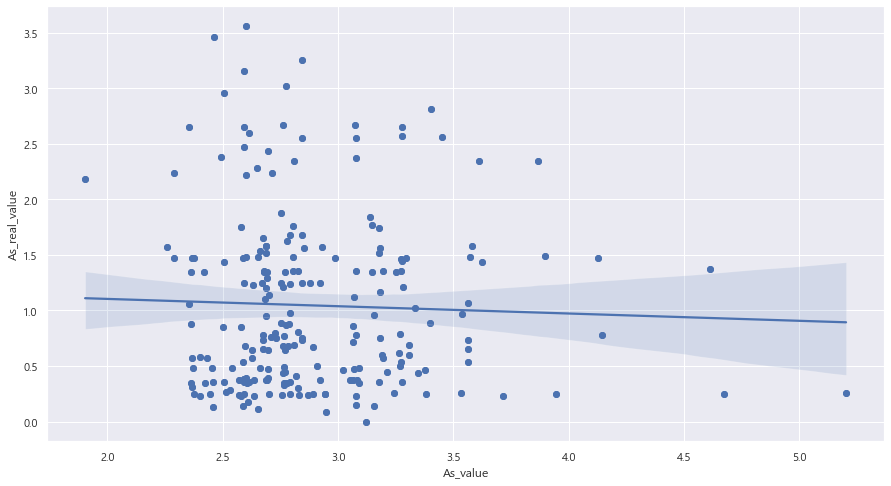

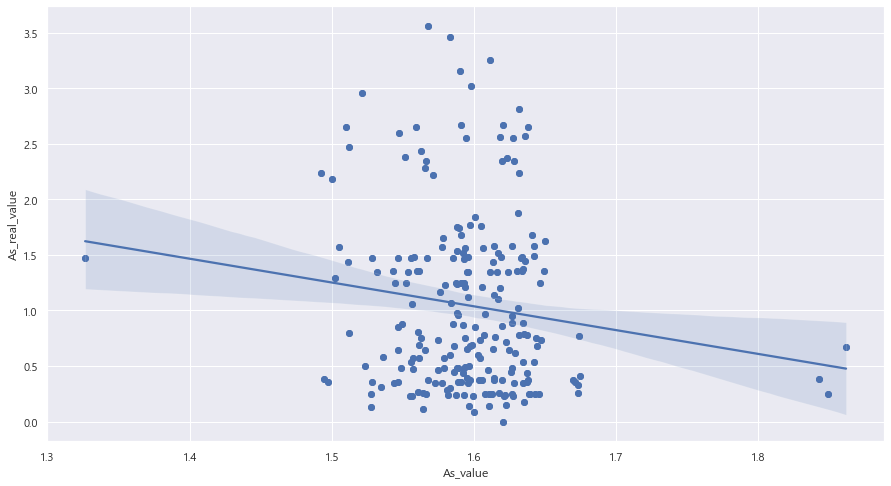

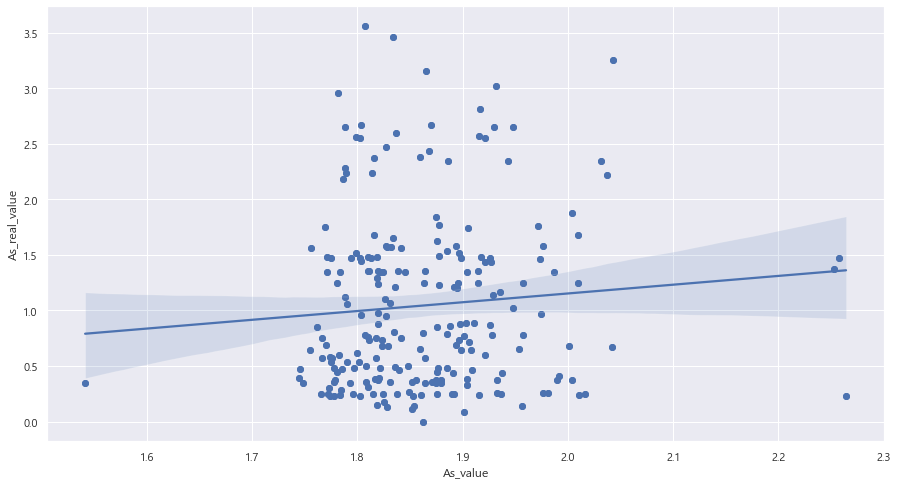

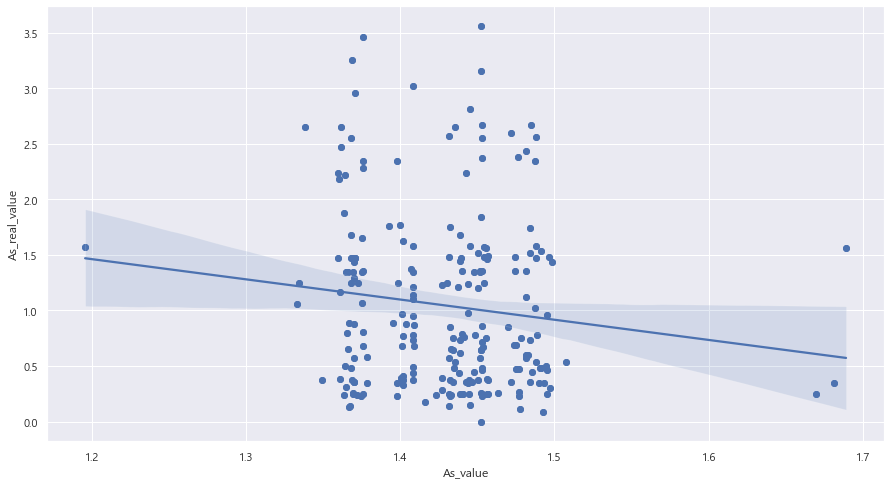

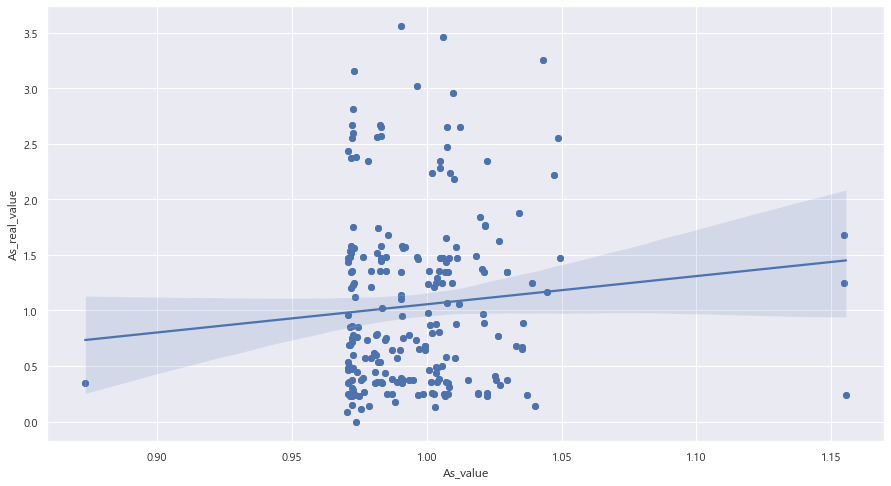

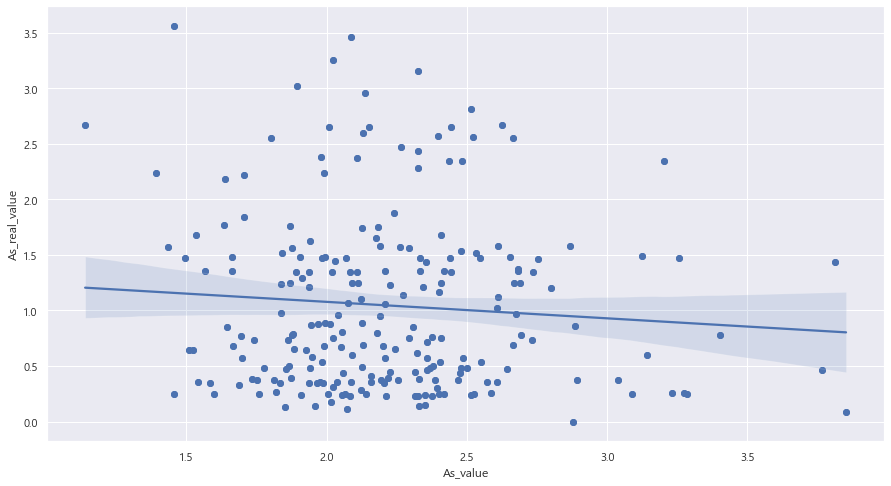

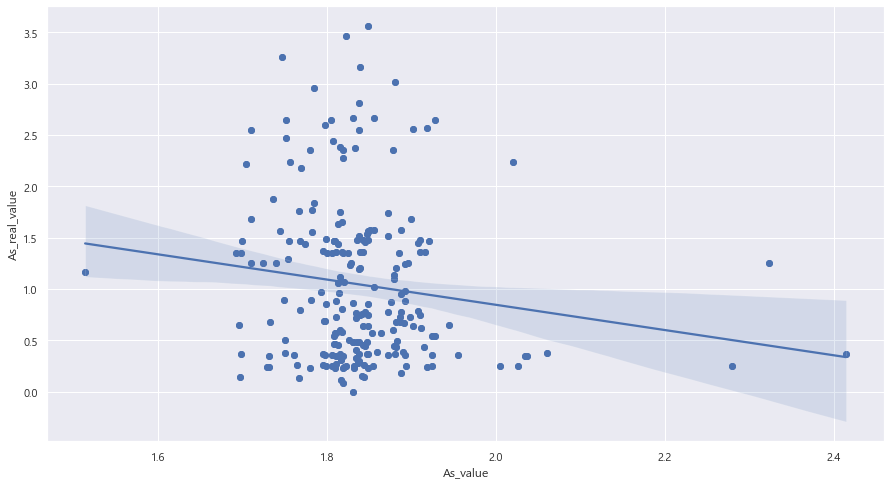

In [359]:
plt.scatter(ngb_As_test['As_value'], ngb_As_test['As_real_value'])
sns.regplot(ngb_As_test['As_value'], ngb_As_test['As_real_value'])
plt.show()

plt.scatter(rf_As_test['As_value'], rf_As_test['As_real_value'])
sns.regplot(rf_As_test['As_value'], rf_As_test['As_real_value'])
plt.show()

plt.scatter(etc_As_test['As_value'], etc_As_test['As_real_value'])
sns.regplot(etc_As_test['As_value'], etc_As_test['As_real_value'])
plt.show()

plt.scatter(gb_As_test['As_value'], gb_As_test['As_real_value'])
sns.regplot(gb_As_test['As_value'], gb_As_test['As_real_value'])
plt.show()

plt.scatter(cb_As_test['As_value'], cb_As_test['As_real_value'])
sns.regplot(cb_As_test['As_value'], cb_As_test['As_real_value'])
plt.show()

plt.scatter(lgbm_As_test['As_value'], lgbm_As_test['As_real_value'])
sns.regplot(lgbm_As_test['As_value'], lgbm_As_test['As_real_value'])
plt.show()

plt.scatter(xgb_As_test['As_value'], xgb_As_test['As_real_value'])
sns.regplot(xgb_As_test['As_value'], xgb_As_test['As_real_value'])
plt.show()

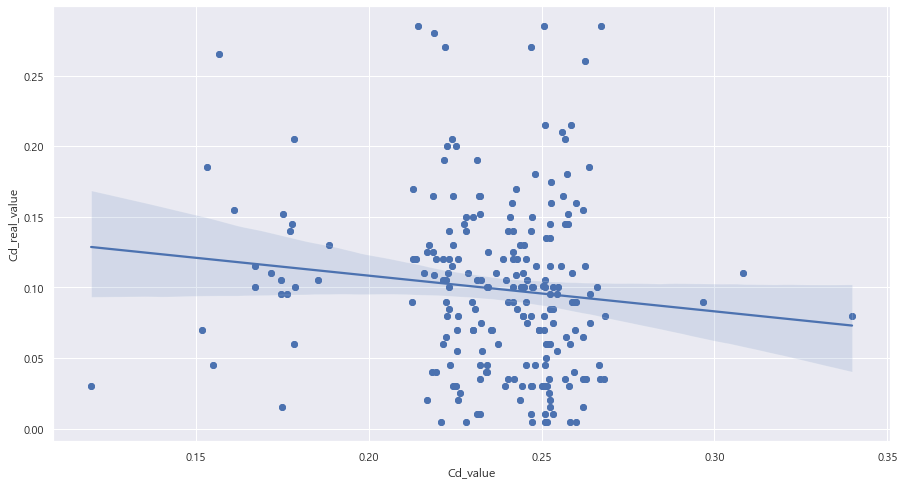

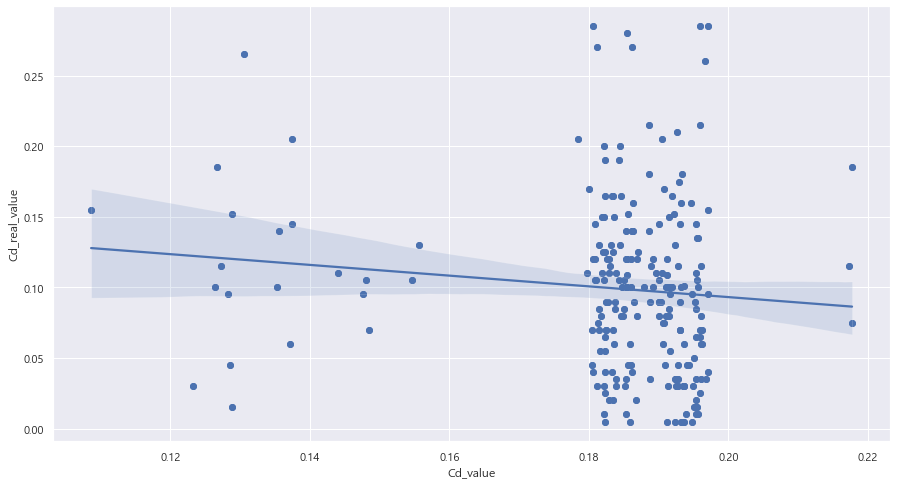

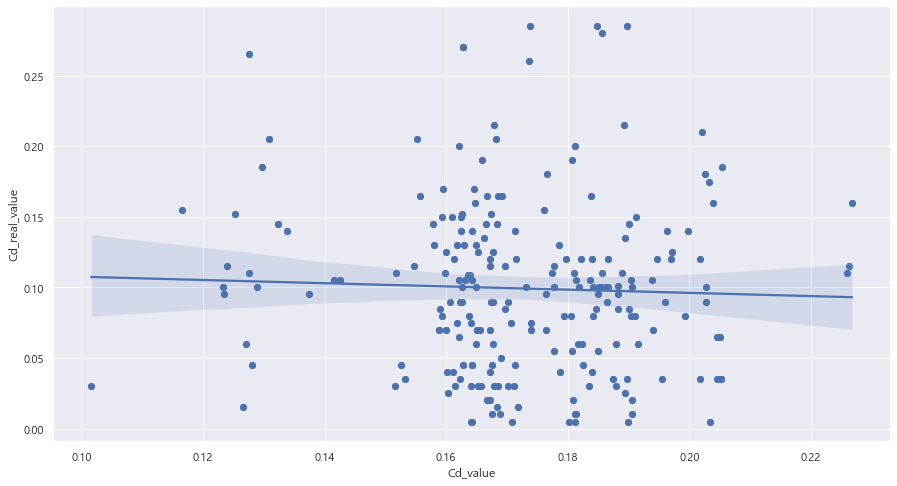

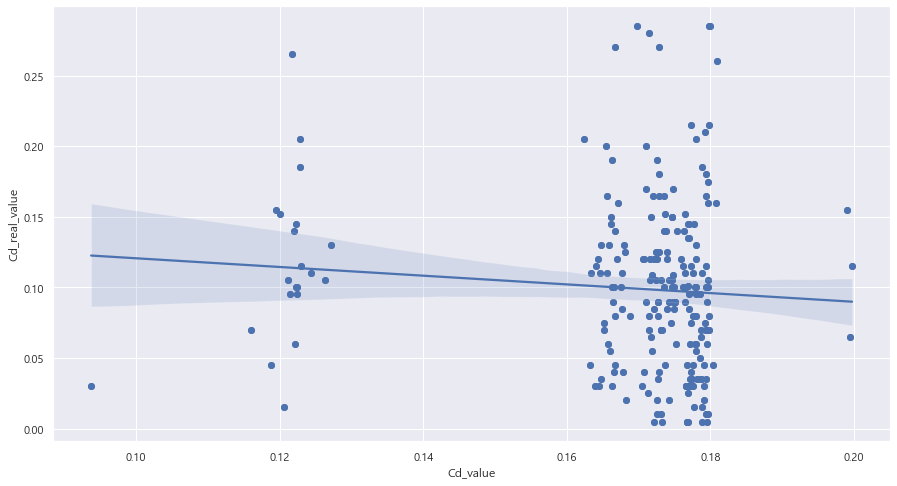

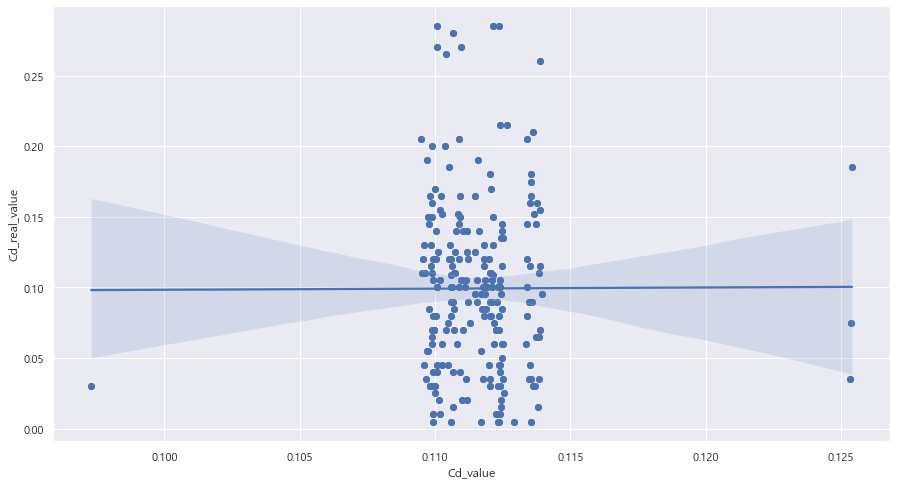

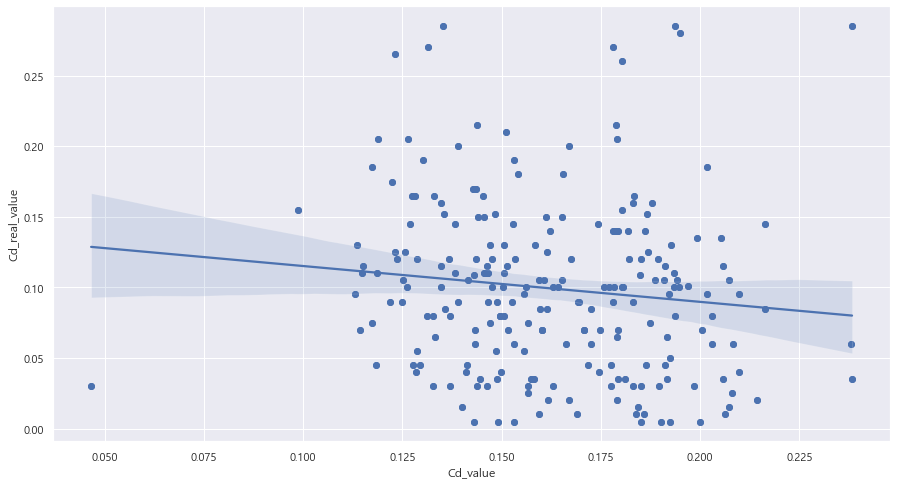

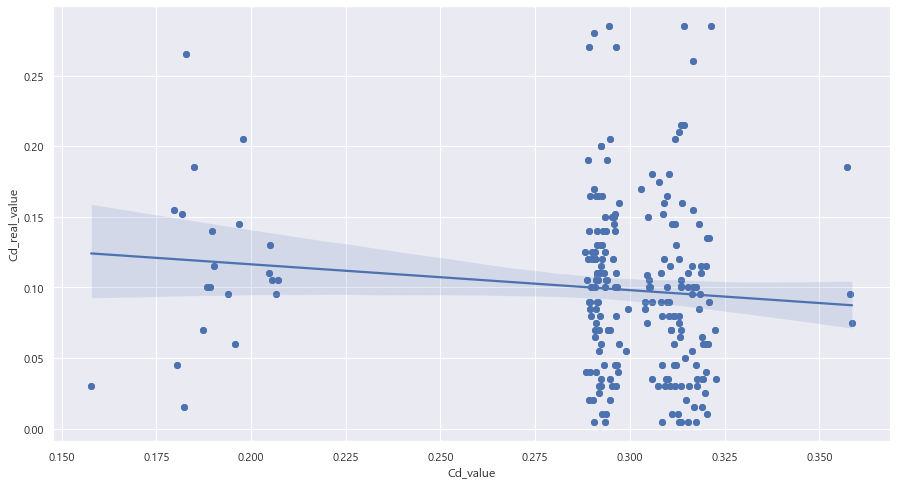

In [360]:
plt.scatter(ngb_Cd_test['Cd_value'], ngb_Cd_test['Cd_real_value'])
sns.regplot(ngb_Cd_test['Cd_value'], ngb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(rf_Cd_test['Cd_value'], rf_Cd_test['Cd_real_value'])
sns.regplot(rf_Cd_test['Cd_value'], rf_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(etc_Cd_test['Cd_value'], etc_Cd_test['Cd_real_value'])
sns.regplot(etc_Cd_test['Cd_value'], etc_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'])
sns.regplot(gb_Cd_test['Cd_value'], gb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(cb_Cd_test['Cd_value'], cb_Cd_test['Cd_real_value'])
sns.regplot(cb_Cd_test['Cd_value'], cb_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(lgbm_Cd_test['Cd_value'], lgbm_Cd_test['Cd_real_value'])
sns.regplot(lgbm_Cd_test['Cd_value'], lgbm_Cd_test['Cd_real_value'])
plt.show()

plt.scatter(xgb_Cd_test['Cd_value'], xgb_Cd_test['Cd_real_value'])
sns.regplot(xgb_Cd_test['Cd_value'], xgb_Cd_test['Cd_real_value'])
plt.show()

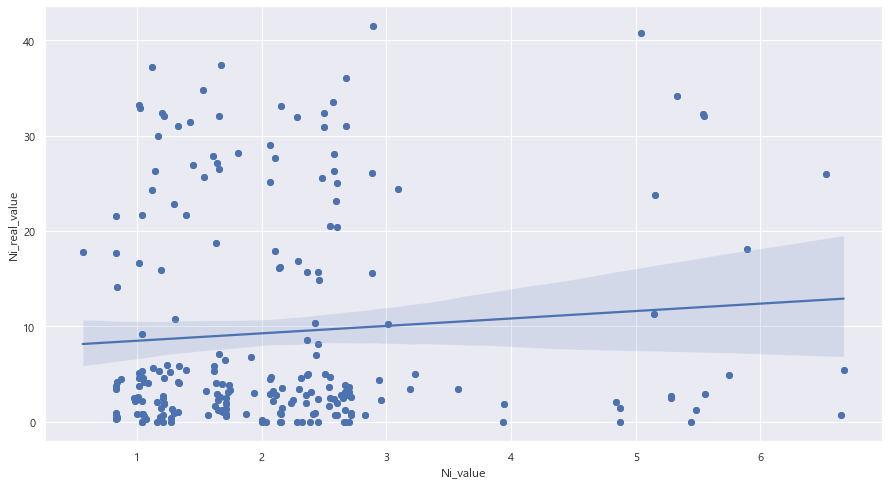

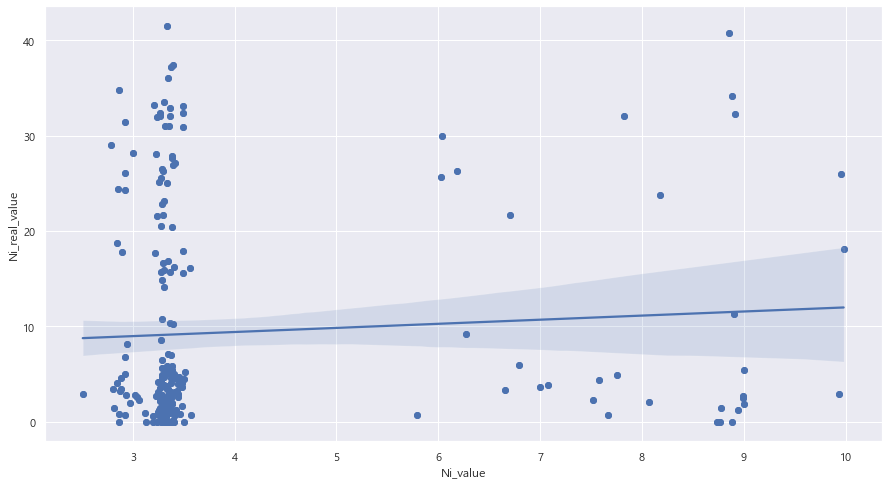

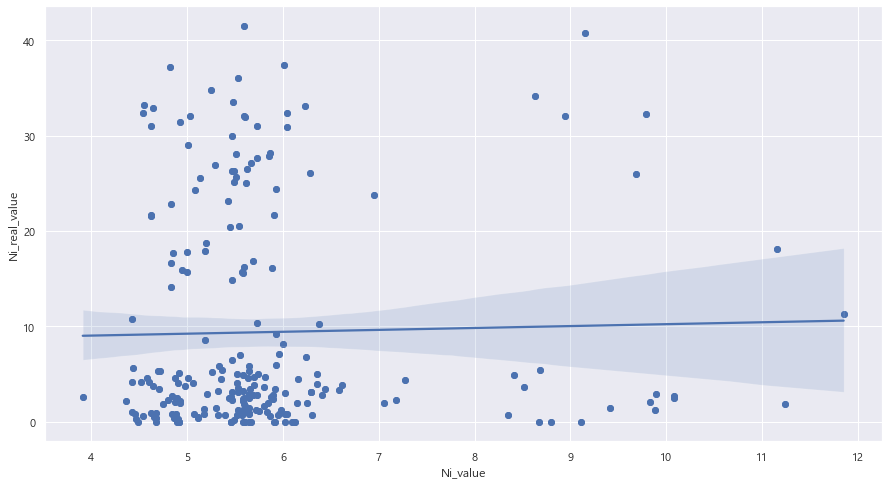

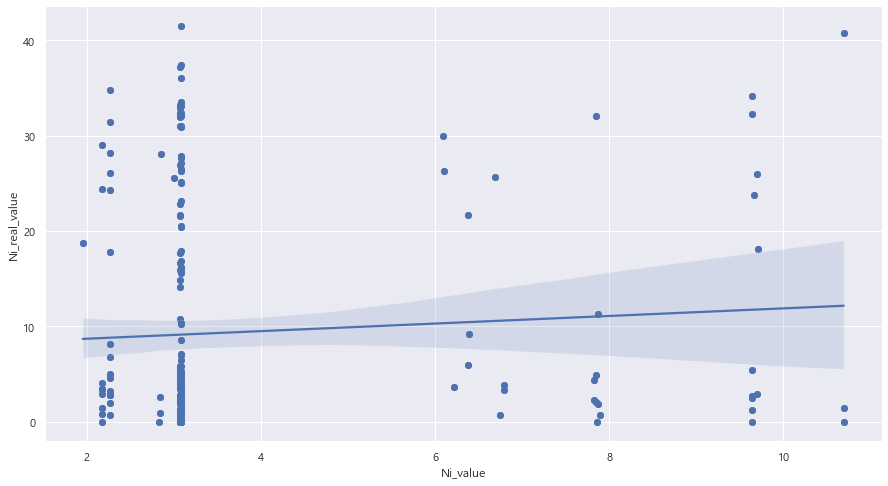

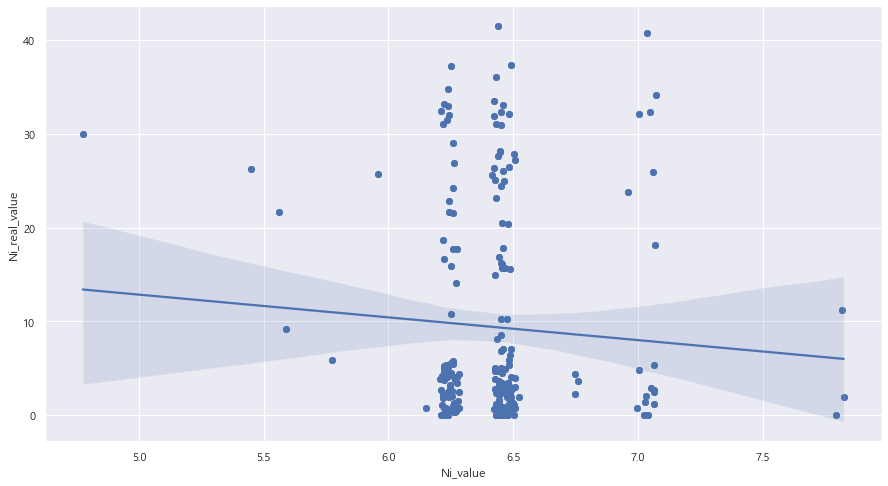

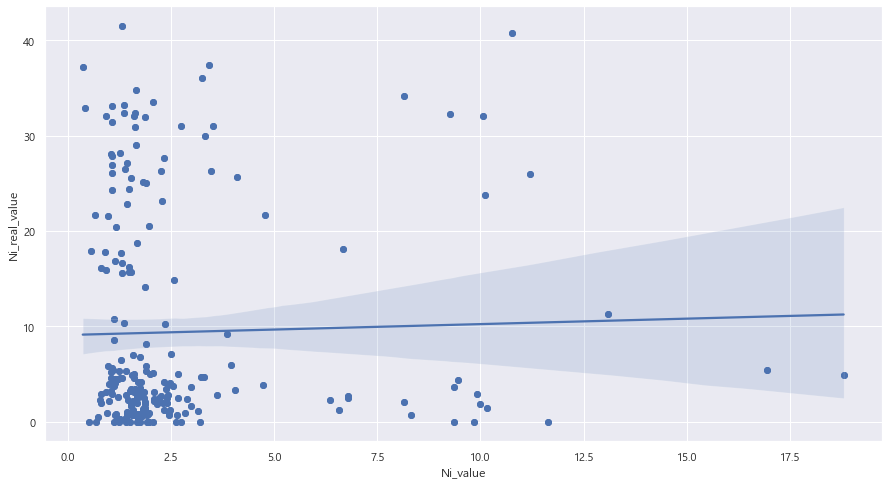

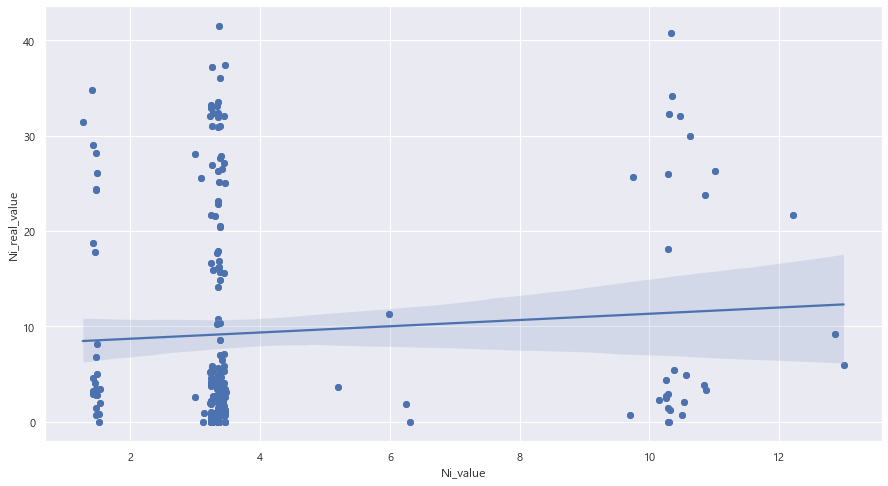

In [361]:
plt.scatter(ngb_Ni_test['Ni_value'], ngb_Ni_test['Ni_real_value'])
sns.regplot(ngb_Ni_test['Ni_value'], ngb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(rf_Ni_test['Ni_value'], rf_Ni_test['Ni_real_value'])
sns.regplot(rf_Ni_test['Ni_value'], rf_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(etc_Ni_test['Ni_value'], etc_Ni_test['Ni_real_value'])
sns.regplot(etc_Ni_test['Ni_value'], etc_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'])
sns.regplot(gb_Ni_test['Ni_value'], gb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(cb_Ni_test['Ni_value'], cb_Ni_test['Ni_real_value'])
sns.regplot(cb_Ni_test['Ni_value'], cb_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(lgbm_Ni_test['Ni_value'], lgbm_Ni_test['Ni_real_value'])
sns.regplot(lgbm_Ni_test['Ni_value'], lgbm_Ni_test['Ni_real_value'])
plt.show()

plt.scatter(xgb_Ni_test['Ni_value'], xgb_Ni_test['Ni_real_value'])
sns.regplot(xgb_Ni_test['Ni_value'], xgb_Ni_test['Ni_real_value'])
plt.show()